Here, we will look at various ways to classify the proteins in our data set.

We will split up the proteins into two classes. The first class contains proteins that do not expresss and proteins that have a Tm of less than 39 C. The second class is all the rest of the proteins. 

In [27]:
%matplotlib inline
import pandas

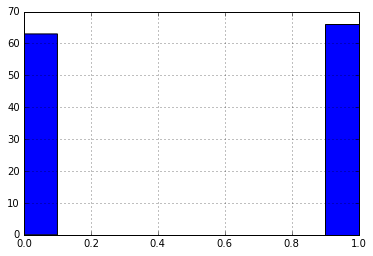

In [28]:
df = pandas.read_csv( '../data_sets/experimental/thermo_paper_data_set.csv', index_col=0 )

my_clf = []

for idx, row in df.iterrows():
    if row.expression == 0 or row.tm < 39.2:
        my_clf.append( 0 ) 
    else:
        my_clf.append( 1 ) 
        
df[ 'my_clf' ] = my_clf 
df.my_clf.hist()

In [29]:
f = pandas.read_csv( 'feature_sets/expression_combined.csv', index_col=0 ).drop( 'expression', axis=1 ) 

software = []

for col in f.columns:
    if '_enzyme_design' in col:
        software.append( 'enzyme_design' ) 
    elif '_foldx' in col:
        software.append( 'foldx' )
    elif '_ddg' in col:
        software.append( 'ddg' ) 

In [30]:
J = df[ [ 'my_clf' ] ].join( f ).dropna()
J.shape

(126, 77)

In [103]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer, classification_report, roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline

In [85]:
scl = StandardScaler()
matt_score = make_scorer( matthews_corrcoef ) 

In [86]:
X = scl.fit_transform( J.ix[ : , 1: ] )
y = J.ix[ : , 0 ].as_matrix().ravel()

print X.shape
print y.shape 

(126, 76)
(126,)


Now we're attacking a problem with balanced classes.

In [109]:
roc_curve?

In [90]:
param_grid = [
    { 
        'svm__kernel': [ 'linear', 'rbf', 'poly' ], 
        'svm__C': [ 3e-2, 3e-1, 3, 3e1 ], 
        'kbest__k': [ 2, 10, 50 ], 
    }
]

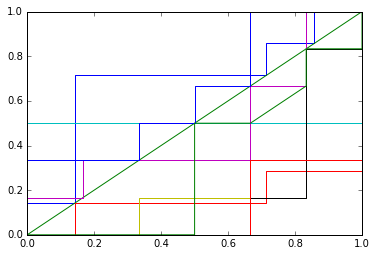

In [111]:
plt.figure()
skf = StratifiedKFold( y, n_folds=10, shuffle=True ) 
for train, test in skf:
        
    pln = Pipeline([('kbest',SelectKBest()), ('svm',SVC(probability=True))])
    clf = GridSearchCV( pln, param_grid, scoring=matt_score )
    preds = clf.fit( X[ train, : ], y[ train ] ).predict( X[ test, : ] ) 
    probs = clf.fit( X[ train, : ], y[ train ] ).predict_proba( X[ test, : ] )[ : , 0 ]
    tpr, fpr, __ = roc_curve( y[ test ], probs ) 
    plt.plot( tpr, fpr ) 
    #print classification_report( y[ test ], preds ) 

In [92]:
preds

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1])